In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.filevideostream import FileVideoStream
from utils.functions import *

In [0]:
def fx_generar_bird_view(good , bad):
    #######################################################
    # Colorear los puntos en un fondo negro en la vista tranformada
    #######################################################
    background_total = np.zeros((3000, 4500, 3), dtype=np.uint8)
    red = (255,0,0)
    green = (0,255,0)

    for point in good:
        cv2.circle(background_total, tuple(point), 25, green, -1)
    
    for point in bad:
        cv2.circle(background_total, tuple(point), 25, red, -1)
    #######################################################
    # Recortar solo la parte de la imagen total de interes
    #######################################################
    #parametros de posición
    cut_posX_min,cut_posX_max = 2000,3400 
    cut_posY_min,cut_posY_max = 200,2800

    #resultados
    #new_size = (cut_posX_max-cut_posX_min, cut_posY_max-cut_posY_min)

    view_birdEye = background_total[cut_posY_min:cut_posY_max, cut_posX_min:cut_posX_max, :]

    #reescalando la bird'eye view
    view_birdEye = cv2.resize(view_birdEye, (600,1000))

    return(view_birdEye)

def fx_generar_frame_final(img , view , logo):
    background = np.ones((1250, 2600, 3), dtype=np.uint8)*150

    # Colorear Cabecera
    background[0:120, : ] = 255

    # Colorear Pie de Video
    background[1200:, : ] = 255

    # Imagen original
    overlay = img.copy()
    weigh_imgOri, high_imgOri, _ = overlay.shape
    pos_x_imgOri, pos_y_imgOri = 120, 0
    background[pos_x_imgOri:pos_x_imgOri+weigh_imgOri, pos_y_imgOri:pos_y_imgOri+high_imgOri ] = overlay

    #Bird Eye
    overlay = view.copy()
    weigh_imgOri, high_imgOri, _ = overlay.shape
    pos_x_imgOri, pos_y_imgOri = 160, 1960
    background[pos_x_imgOri:pos_x_imgOri+weigh_imgOri, pos_y_imgOri:pos_y_imgOri+high_imgOri ] = overlay

    # Logo
    overlay = logo.copy()
    weigh_imgOri, high_imgOri, _ = overlay.shape
    pos_x_imgOri, pos_y_imgOri = 10, 25
    background[pos_x_imgOri:pos_x_imgOri+weigh_imgOri, pos_y_imgOri:pos_y_imgOri+high_imgOri ] = overlay

    ######################################################################################33
    # Agregando Textos: 
    frame_final_new = background.copy()

    # Titulo Video Original
    cv2.putText(frame_final_new,  
            "Detector de Distanciamiento Social",  
            (400,90),  
            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,  
            fontScale=3,  
            color=(38, 82, 133),
            thickness=4)

    # Titulo Bird's Eye View
    cv2.putText(frame_final_new,  
            "Bird's Eye View",  
            (1975,90),  
            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,  
            fontScale=3,  
            color=(38, 82, 133),
            thickness=4)

    # Pie de Video
    cv2.putText(frame_final_new,  
            "Proyecto Final del curso de Computer Vision del Diplomado de Inteligencia Artificial",  
            (10,1230),  
            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,  
            fontScale=1.2,  
            color=(38, 82, 133),
            thickness=2)

    frame_final_new = cv2.copyMakeBorder(frame_final_new, 2,2,2,2, cv2.BORDER_CONSTANT)

    return(frame_final_new)

#### 1. Prueba con imagen

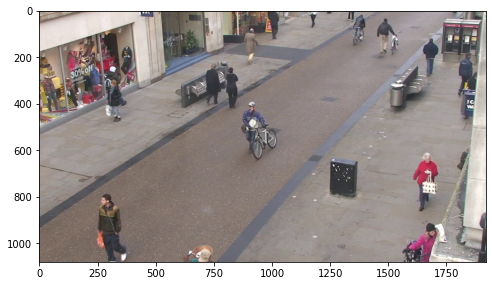

In [22]:
original = cv2.cvtColor(cv2.imread('multimedia/calibration_frame.jpg'), cv2.COLOR_BGR2RGB)
image_copy = original.copy()

plt.figure(figsize=(8,8))
plt.imshow(image_copy)
plt.show()

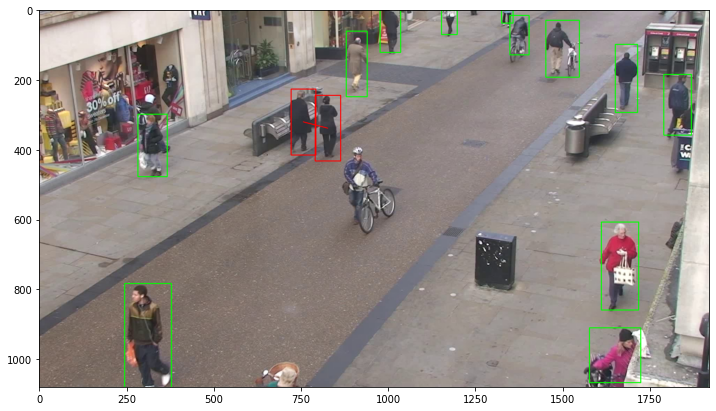

CPU times: user 4.77 s, sys: 289 ms, total: 5.06 s
Wall time: 3.13 s


In [23]:
%%time
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 100
width = 416
height = 416

config = 'models/yolov3-608/yolov3.cfg'
weights = 'models/yolov3-608/yolov3.weights'
classes = 'models/yolov3-608/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

model = create_model(config, weights, use_gpu=False)
output_layers = get_output_layers(model)
blob = blob_from_image(image_copy, (width, height))
outputs = predict(blob, model, output_layers)
boxes, nms_boxes, class_ids = non_maximum_suppression(image_copy, outputs, confidence_threshold, nms_threshold)
person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
new_image  = draw_new_image_with_boxes(image_copy, good, bad, min_distance, draw_lines=True)

plt.figure(figsize=(12,12))
plt.imshow(new_image)
plt.show()

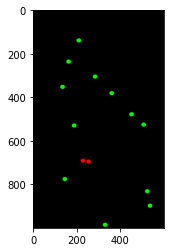

In [24]:
green_points = [g[6:] for g in good]
red_points = [r[6:] for r in bad]

bird_eye_view_points = fx_generar_bird_view(green_points, red_points)
plt.imshow(bird_eye_view_points)
plt.show()

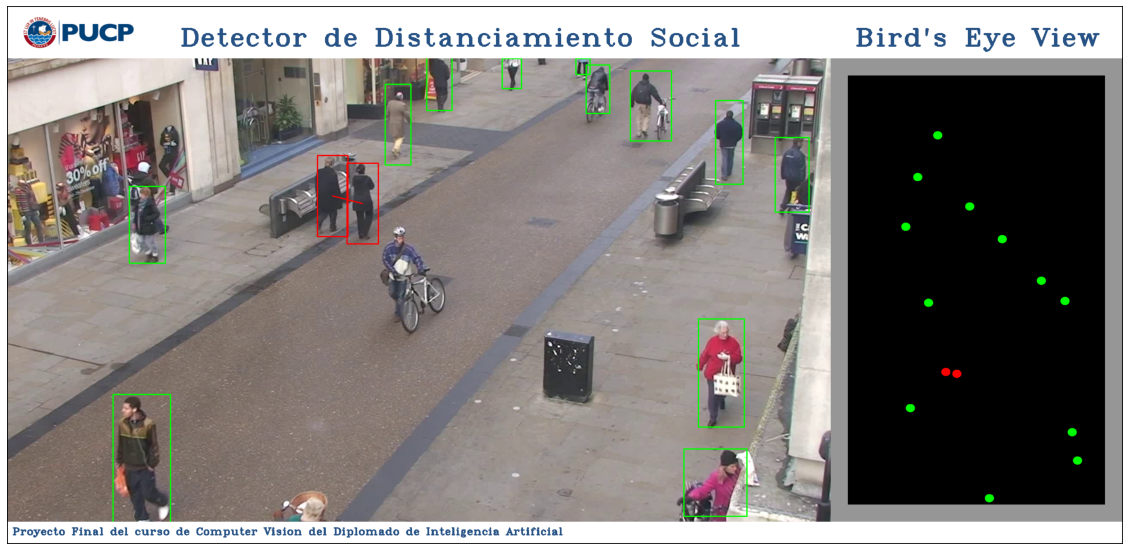

In [31]:
img_logo = cv2.cvtColor(cv2.imread('multimedia/LogoPUCP.png'), cv2.COLOR_BGR2RGB) 
img_logo = cv2.resize(img_logo,(280,100))

frame_final = fx_generar_frame_final(new_image, bird_eye_view_points, img_logo)
plt.figure(figsize=(20, 20))
plt.imshow(frame_final)
plt.axis('off')
plt.show()

#### 2. Prueba con video

In [38]:
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 100
width = 416
height = 416

config = 'models/yolov3-608/yolov3.cfg'
weights = 'models/yolov3-608/yolov3.weights'
classes = 'models/yolov3-608/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

writer = None
W = None
H = None    

video = cv2.VideoCapture('multimedia/TownCentre-test.mp4')
    
model = create_model(config, weights, use_gpu=False)
output_layers = get_output_layers(model)

img_logo = cv2.cvtColor(cv2.imread('multimedia/LogoPUCP.png'), cv2.COLOR_BGR2RGB) 
img_logo = cv2.resize(img_logo,(280,100))

while True:
  
  _,frame = video.read()
  
  if frame is None:
      break
  
  if W is None or H is None:
    (H, W) = [1254,2604] #frame.shape[:2]    

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('multimedia/output.avi', fourcc, 30, (W, H), True)

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  blob = blob_from_image(image, (width, height))
  outputs = predict(blob, model, output_layers)
  boxes, nms_boxes, class_ids = non_maximum_suppression(image, outputs, confidence_threshold, nms_threshold)
  person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

  good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
  new_image  = draw_new_image_with_boxes(image, good, bad, min_distance, draw_lines=True)
  
  green_points = [g[6:] for g in good]
  red_points = [r[6:] for r in bad]
  bird_eye_view_points = fx_generar_bird_view(green_points, red_points)

  frame_final = fx_generar_frame_final(new_image, bird_eye_view_points, img_logo)

  if writer is not None:
    print(frame_final.shape)
    writer.write(frame_final[:,:,::-1])
      
if writer is not None:
  writer.release()

video.release()

(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2604, 3)
(1254, 2

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp multimedia/output.avi /content/drive/My\ Drive/output_v2.avi